In [1]:
import os
import numpy as np
import torch
from PIL import Image
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

from copy import deepcopy
from torch.utils.data import DataLoader
from torch.nn import CrossEntropyLoss
from torch.optim import Adam

# Image Imports
first we import our dataset and transform it to tensor format

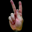

In [2]:
example = Image.open('asl_dataset/k/hand4_k_bot_seg_5_cropped.jpeg').resize((32, 32))
example

In [4]:
#Creation of a dictionary to encode the labels in a sequence of 0 and 1
path= 'working'
character_types = os.listdir(f'{path}/test/')

character_len_dic ={}
ones=np.identity(26)
labels_dict={}
for i in range(len(character_types)):
    labels_dict[character_types[i]] =ones[i]

In [5]:
#To extract the average and std of the training set we need all pixels in a list. We will need it to normalize our dataset
for_average=[]
for character in character_types:
    dir_path = f'{path}/test/{character}'
    character_len_dic[character] = len(os.listdir(dir_path))
    for img in os.listdir(dir_path):
        image = Image.open(f'{dir_path}/{img}').resize((32,32))
        img_np = np.rollaxis(np.array(image), -1)
        for channel in img_np:
            for pixel in channel:
                for_average.append(pixel)

In [6]:
mean = np.mean(np.asarray(for_average))
std = np.std(np.asarray(for_average))

In [7]:
# we Load the training Set
train_set=[]
for character in character_types:
    dir_path = f'{path}/train/{character}'
    character_len_dic[character] = len(os.listdir(dir_path))
    for img in os.listdir(dir_path):
        image = Image.open(f'{dir_path}/{img}').resize((32,32))
        img_torch = torch.tensor(np.rollaxis(np.array(image), -1), dtype=torch.float32)
        img_torch = (img_torch - mean) / std
        label_torch = torch.tensor(labels_dict[character], dtype=torch.float32)
        train_set.append((img_torch, label_torch))

In [8]:
# we Load the validation Set
val_set=[]
for character in character_types:
    dir_path = f'{path}/val/{character}'
    character_len_dic[character] = len(os.listdir(dir_path))
    for img in os.listdir(dir_path):
        image = Image.open(f'{dir_path}/{img}').resize((32,32))
        img_torch = torch.tensor(np.rollaxis(np.array(image), -1), dtype=torch.float32)
        img_torch = (img_torch - mean) / std
        label_torch = torch.tensor(labels_dict[character], dtype=torch.float32)
        val_set.append((img_torch, label_torch))

In [9]:
# We load the test Set
test_set=[]
for character in character_types:
    dir_path = f'{path}/test/{character}'
    character_len_dic[character] = len(os.listdir(dir_path))
    for img in os.listdir(dir_path):
        image = Image.open(f'{dir_path}/{img}').resize((32,32))
        img_torch = torch.tensor(np.rollaxis(np.array(image), -1), dtype=torch.float32)
        img_torch = (img_torch - mean) / std
        label_torch = torch.tensor(labels_dict[character], dtype=torch.float32)
        test_set.append((img_torch, label_torch))

In [10]:
n_images_train = len(train_set)
n_images_test = len(test_set)
n_images_val = len(val_set)

# Model: LeNet
We are going to apply a modification of LeNet-5. the only difference is that we have not converted our images to grayscale.
https://medium.com/@siddheshb008/lenet-5-architecture-explained-3b559cb2d52b

In [11]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 6, 5, padding=2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1   = nn.Linear(16*6*6, 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 26)

    def forward(self, x):
      
        x = F.max_pool2d(F.relu(self.conv1(x)), kernel_size=2,stride=2)
        x = F.max_pool2d(F.relu(self.conv2(x)), kernel_size=2,stride=2)
        x = x.reshape(-1,576)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.fc3(x), dim=1)
        return x

    def get_number_of_parameters(self):
        return sum(p.numel() for p in self.parameters())

# Training
To train the model we will use the Adam optimizer and Cross Entropy loss function

In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = LeNet().to(device)

print('model number of parameters:', model.get_number_of_parameters())

model number of parameters: 84486


In [13]:
train_loader = DataLoader(train_set, batch_size=4, shuffle=True, drop_last=True)
test_loader = DataLoader(test_set, batch_size=1, shuffle=False)
val_loader = DataLoader(val_set, batch_size=4, shuffle=False)

loss_function = CrossEntropyLoss()

optimizer = Adam(model.parameters(), lr=5e-4, weight_decay=1e-5)

In [14]:
epochs = 60

train_loss, train_accuracy = [], []
val_loss, val_accuracy = [], []
test_loss, test_accuracy = [], []
best_model = deepcopy(model)
best_val_loss = torch.inf

for epoch in range(epochs):
    model.train()
    train_loss_epoch, train_accuracy_epoch = 0,0
    for img, labels in train_loader:
        input_data = img.to(device)
        labels = labels.to(device)
        outputs = model(input_data)
        loss = loss_function(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss_epoch += loss.item() * len(labels)
        correct = torch.argmax(outputs, dim=1) == torch.argmax(labels, dim=1)
        train_accuracy_epoch += correct.sum().item()


    train_loss_epoch /= n_images_train
    train_accuracy_epoch /= (n_images_train / 100)
    train_loss.append(train_loss_epoch)
    train_accuracy.append(train_accuracy_epoch)

    model.eval()
    test_loss_epoch, test_accuracy_epoch = 0, 0
    for img, labels in test_loader:
        input_data = img.to(device)
        labels = labels.to(device)
        outputs = model(input_data)
        loss = loss_function(outputs, labels)
        test_loss_epoch += loss.item() * len(labels)
        correct = torch.argmax(outputs, dim=1) == torch.argmax(labels, dim=1)
        test_accuracy_epoch += correct.sum().item()

    test_loss_epoch /= n_images_val
    test_accuracy_epoch /= (n_images_test / 100)
    test_loss.append(test_loss_epoch)
    test_accuracy.append(test_accuracy_epoch)
    
    val_loss_epoch, val_accuracy_epoch = 0, 0
    for img, labels in val_loader:
        input_data = img.to(device)
        labels = labels.to(device)
        outputs = model(input_data)
        loss = loss_function(outputs, labels)
        val_loss_epoch += loss.item() * len(labels)
        correct = torch.argmax(outputs, dim=1) == torch.argmax(labels, dim=1)
        val_accuracy_epoch += correct.sum().item()
       
    val_loss_epoch /= n_images_val
    val_accuracy_epoch /= (n_images_val / 100)
    val_loss.append(val_loss_epoch)
    val_accuracy.append(val_accuracy_epoch)

    if val_loss_epoch < best_val_loss:
        best_val_loss = val_loss_epoch
        best_model = deepcopy(model)

    print('epoch: {}, training loss: {:.3f}, test loss: {:.3f}, val loss: {:.3f}'.format(epoch+1, train_loss_epoch, test_loss_epoch, val_loss_epoch))
    print('epoch: {}, training accuracy: {:.2f}%, test accuracy: {:.2f}%, val accuracy: {:.2f}% \n'.format(epoch+1, train_accuracy_epoch, test_accuracy_epoch, val_accuracy_epoch))

epoch: 1, training loss: 3.130, test loss: 2.982, val loss: 2.950
epoch: 1, training accuracy: 19.49%, test accuracy: 36.26%, val accuracy: 38.12% 

epoch: 2, training loss: 2.917, test loss: 2.944, val loss: 2.900
epoch: 2, training accuracy: 41.12%, test accuracy: 38.46%, val accuracy: 41.99% 

epoch: 3, training loss: 2.871, test loss: 2.892, val loss: 2.877
epoch: 3, training accuracy: 45.25%, test accuracy: 45.05%, val accuracy: 44.75% 

epoch: 4, training loss: 2.867, test loss: 2.893, val loss: 2.868
epoch: 4, training accuracy: 45.52%, test accuracy: 45.05%, val accuracy: 45.30% 

epoch: 5, training loss: 2.848, test loss: 2.881, val loss: 2.838
epoch: 5, training accuracy: 47.45%, test accuracy: 45.60%, val accuracy: 48.07% 

epoch: 6, training loss: 2.834, test loss: 2.857, val loss: 2.823
epoch: 6, training accuracy: 48.76%, test accuracy: 48.35%, val accuracy: 50.28% 

epoch: 7, training loss: 2.828, test loss: 2.856, val loss: 2.821
epoch: 7, training accuracy: 49.38%, tes

Here we can see a visualization of the training process. We can see how the loss decreases and the accuracy increases

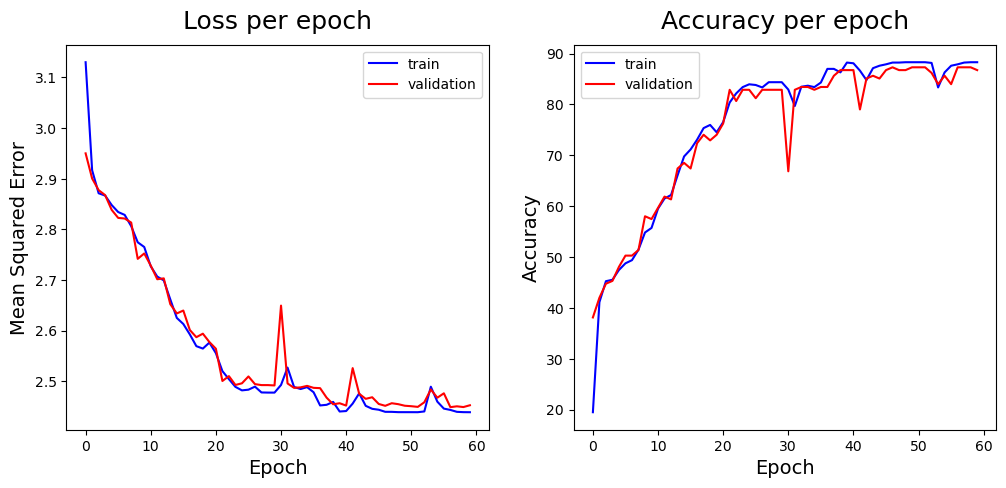

In [15]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(12,5))
ax[0].plot(train_loss, c='b', label='train')
ax[0].plot(val_loss, c='r', label='validation')
ax[0].set_xlabel('Epoch', fontsize=14)
ax[0].set_ylabel('Mean Squared Error', fontsize=14)
ax[0].set_title('Loss per epoch', fontsize=18, y=1.02)
ax[0].legend()
ax[1].plot(train_accuracy, c='b', label='train')
ax[1].plot(val_accuracy, c='r', label='validation')
ax[1].set_xlabel('Epoch', fontsize=14)
ax[1].set_ylabel('Accuracy', fontsize=14)
ax[1].set_title('Accuracy per epoch', fontsize=18, y=1.02)
ax[1].legend()

# Model Evaluation

In [17]:
decript_dict={}
for i in range(len(character_types)):
    decript_dict[i]=character_types[i]

In [18]:
best_model.eval()
forecasts=[]
test_accuracy = 0
for img, labels in test_loader:
    input_data = img.to(device)
    labels = labels.to(device)
    outputs = best_model(input_data)
    correct = torch.argmax(outputs, dim=1) == torch.argmax(labels, dim=1)
    test_accuracy += correct.sum().item()
    forecasts.append((decript_dict[torch.argmax(labels, dim=1).item()],decript_dict[torch.argmax(outputs, dim=1).item()]))
test_accuracy /= n_images_test

print('The accuracy on the test set of the best model is {:.2f}%'.format(100 * test_accuracy))

The accuracy on the test set of the best model is 82.42%


In [19]:
df=pd.DataFrame(forecasts, columns=['label','prediction'])

Here we have the confusion matrix to see what labels were missclassified the most. We can see this model is unable to classify in the test set the A, H and M characters

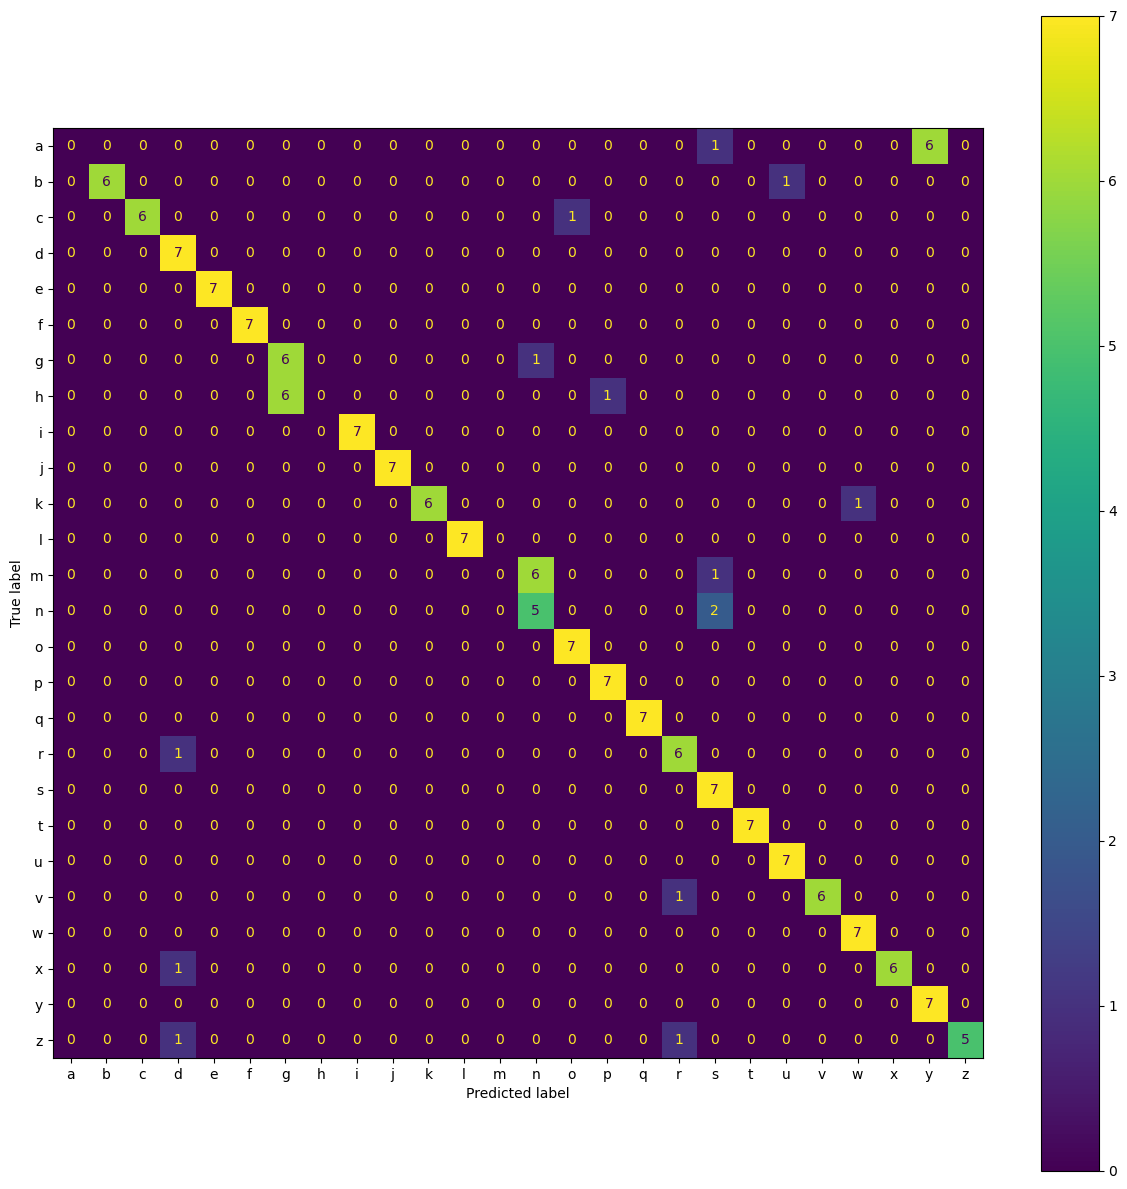

In [30]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

actual = df['label']
predicted = df['prediction']

confusion_matrix = metrics.confusion_matrix(actual, predicted)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = list(decript_dict.values()))

fig, ax = plt.subplots(figsize=(15,15))
cm_display.plot(ax=ax)

In [23]:
fig.savefig("confusion_LeNet.png")

In [21]:
df['correct']=df['label']==df['prediction']

In [24]:
import seaborn as sns

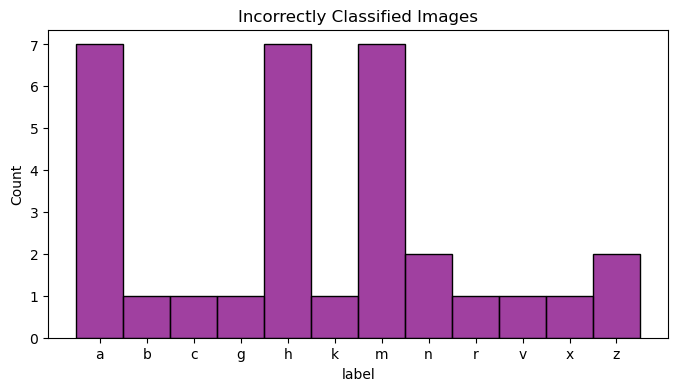

In [31]:
plt.figure(figsize=(8, 4))
ax = sns.histplot(data=df[df["correct"] == False], x="label", color='purple')
ax.set_title('Incorrectly Classified Images')
plt.show()